In [2]:
%load_ext autoreload
%autoreload 2
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
import matplotlib.pyplot as plt
import torch

import neural_metric
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
import numpy as np
import torch.nn.functional as F
import main_eval 
import default_config

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend


# Evaluate Synthetic Data

### From analytic form of immersion

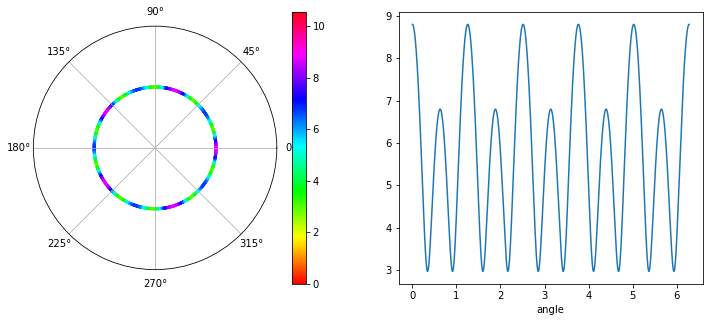

In [54]:
angles = gs.linspace(0,2*gs.pi,1000)

params = {
    "immersion_type": "analytic",
    "radius": 1,
    "n_wiggles": 5,
    "amp_wiggles": 0.3,
    "embedding_dim": 5,
    "model_filename": None,
    "rot": SpecialOrthogonal(n=5).random_point()
}


mean_curv_vectors = main_eval.mean_curv_vector(angles,params)

mean_curv_norms = [gs.linalg.norm(vec) for vec in mean_curv_vectors]

main_eval.plot(angles,mean_curv_norms)

## Learned immersion via VAE

### Load model

In [168]:
model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/wiggles_2022-09-07 16:57:00_model.pt"

model = torch.load(model_filename)


# from models.spherical_vae import SphericalVAE
# model1 = SphericalVAE(input_dim=6,
#                      encoder_dims=[40,40,40,40,40],
#                      latent_dim=2,
#                      distribution="vmf")

# model1.load_state_dict(torch.load("/Users/franciscoacosta/Desktop/code/abn/abn/results/modelsd.pt"))

# model1.eval()

### Compare reconstruction with inputs

Dataset shape: torch.Size([1000, 4]).


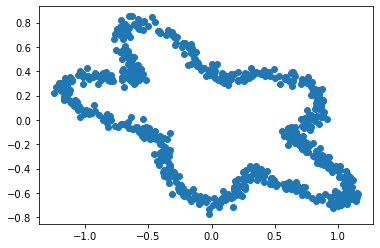

In [174]:
from datasets import utils
dataset_torch, labels, train_loader, test_loader = datasets.utils.load(default_config)

x = [train_loader.dataset[i][0][0] for i in range(700)]
y = [train_loader.dataset[i][0][1] for i in range(700)]

plt.scatter(x,y)

In [175]:
thetas = torch.linspace(0,2*torch.pi,1000)
z = torch.stack([torch.cos(thetas), torch.sin(thetas)],axis=-1)

rec = model.decode(z)

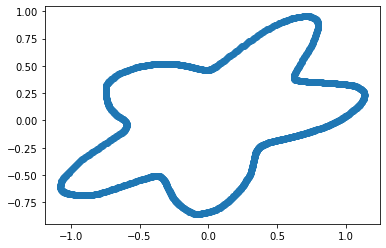

In [176]:
x_rec = rec[0][:,0].cpu().detach().numpy()
y_rec = rec[0][:,1].cpu().detach().numpy()

plt.scatter(x_rec,y_rec)

In [177]:
from datasets.synthetic import load_wiggles


dataset, labels = load_wiggles(default_config.rot,
    n_times=default_config.n_times,
    synth_radius=default_config.synth_radius,
    n_wiggles=default_config.n_wiggles,
    amp_wiggles=default_config.amp_wiggles,
    embedding_dim=default_config.embedding_dim,
    noise_var=default_config.noise_var)

_, posterior_params = model(dataset)


/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [178]:
z = model.reparameterize(posterior_params)[0]

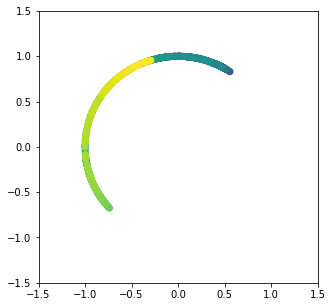

In [179]:
plt.figure(figsize=(5,5))
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

z0 = z[:,0].cpu().detach().numpy()
z1 = z[:,1].cpu().detach().numpy()

plt.scatter(z0,z1,c=labels["angles"])

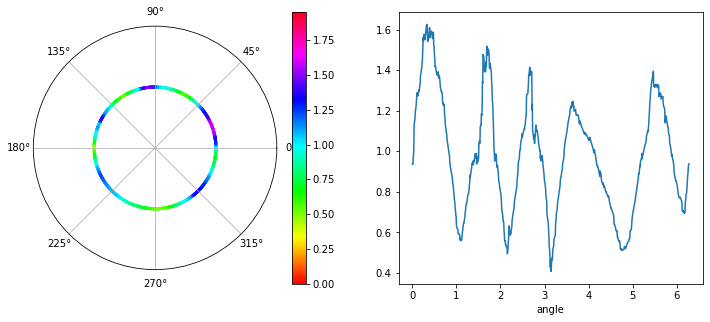

In [180]:
params = {
    "immersion_type": "VAE",
    "radius": None,
    "n_wiggles": None,
    "amp_wiggles": None,
    "embedding_dim": default_config.embedding_dim,
    "model": model,
}

angles = gs.linspace(0,2*gs.pi,1000)

mean_curv_vectors = main_eval.mean_curv_vector(angles,params)

mean_curv_norm = [gs.linalg.norm(vec) for vec in mean_curv_vectors]

main_eval.plot(angles,mean_curv_norm)

In [51]:
immersion2 = neural_metric.get_neural_immersion(model2)

In [54]:
theta = torch.tensor(torch.pi/3)

func = lambda x: immersion2(x)[0]

g = torch.autograd.functional.hessian(func,inputs=theta, strict=True)

In [28]:
immersion1(theta)

tensor(2.0479, grad_fn=<UnbindBackward0>)

In [52]:
immersion2(theta)

tensor([-0.7135, -0.0035, -1.9717, -1.8315, -1.1628], grad_fn=<AddBackward0>)

In [30]:
def get_immersion(model):
    def imm(theta):
        z = torch.tensor([torch.cos(theta), torch.sin(theta)])
        x_rec = model.decode(z)
        return x_rec
    return imm

In [42]:
immersion1 = get_immersion(model1)

In [43]:
immersion1(theta)

tensor([-0.5145, -0.2627, -1.0943,  0.3953,  0.2808, -0.9181],
       grad_fn=<AddBackward0>)

In [37]:
def mean_curv(base_point, immersion, embedding_dim):
    H = torch.zeros(embedding_dim)
    for i in range(embedding_dim):
        H[i] = torch.autograd.functional.hessian(
            func=lambda x: immersion(x)[i], inputs=base_point, strict=True
        )
    return H

In [53]:
H1 = mean_curv(theta,immersion2, 2)

In [39]:
H2 = mean_curv(theta, immersion2, 5)

In [40]:
H2

tensor([-0.0118,  0.0263,  0.0093, -0.0090,  0.0040])